# Yet another attempt to train a model that doesn't take ages
## Strategy here: first compute and save all spectrograms, then sample from spectrograms for training

### Imports

In [51]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import h5py

import tensorflow as tf
# Set logging level to avoid unnecessary messages
tf.get_logger().setLevel('ERROR')
# Set autograph verbosity to avoid unnecessary messages
tf.autograph.set_verbosity(0)

import keras
import tensorflow_io as tfio
import tensorflow_probability as tfp
import tensorflow_extra as tfe

import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

from pathlib import Path
import sys
import os
import time
import warnings
# suppress all warnings
warnings.filterwarnings("ignore")

XC_ROOTDIR = '../../data/' # directory to save data in
XC_DIR = 'test_dataset10' # subdirectory name of dataset

tf.config.set_visible_devices([], 'GPU')

### Read data

In [52]:
df = pd.read_csv("../../data/dataset10.csv")
df["fullfilename"] = "../" + df["fullfilename"]

### Configuration

In [53]:
class cfg:
    # random seed
    seed = 42

    # audio clip settings
    sr = 22050
    duration = 15 # the duration of the clips
    
    n_samples = duration*sr
    
    hop_length = 2048 # "stepsize" of the fft for the melspectrograms
    nfft = 4096 # windowsize of the fft for the melspectrograms
    n_mels = 128 # number of mel frequency bins
    fmax = sr/2 # maximum frequency in the melspectrograms
    input_dim = (n_mels, int(duration*sr//hop_length + 1))
    
    # training settings
    batch_size = 32
    n_epochs = 50
    
    # class labels/names
    names = list(np.unique(df.en))
    n_classes = len(names)
    labels = list(range(n_classes))
    label2name = dict(zip(labels, names))
    name2label = {v:k for k,v in label2name.items()}

# set random seed in keras
tf.keras.utils.set_random_seed(cfg.seed)

## Load all audios, compute and save spectrograms

### Functions to compute, save and load spectrogram

In [54]:
def compute_spec(filepath, sr=cfg.sr, duration=cfg.duration, nfft=cfg.nfft, hop_length=cfg.hop_length, n_mels=cfg.n_mels, fmax=cfg.fmax):
    audio, sr = librosa.load(filepath, sr = sr)
    # randomly pad clip if shorter
    if len(audio) < duration*sr:
        _ = np.zeros(duration*sr)
        rand_idx = np.random.randint(0, duration*sr-len(audio))
        _[rand_idx:rand_idx + len(audio)] = audio
        audio = _
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=nfft, hop_length=hop_length, n_mels=n_mels, fmin = 0, fmax=fmax)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
    return log_mel_spectrogram

def save_spec_to_hdf5(spec, hdf5_path, name, compression="gzip", chunks=True):
    try:
        with h5py.File(hdf5_path, 'a') as f:  # Open in append mode
            f.create_dataset(name, data=spec, compression=compression, chunks=chunks)
    except Exception as e:
        print(f'Error saving spectrograms to {hdf5_path}: {e}')

In [55]:
def compute_and_save_spec(filepath, return_length = False):
    spec = compute_spec(filepath)
    name = Path(filepath).stem
    hdf5_path = os.path.dirname(filepath) + "/spectrograms.h5"
    save_spec_to_hdf5(spec, hdf5_path = hdf5_path, name = name)
    if return_length:
        return spec.shape[-1]

def load_spectrogram_slice(hdf5_path, name, start_row = 0, end_row =None, start_col = 0, end_col = None):
    with h5py.File(hdf5_path, 'r') as f:
        spectrogram_slice = f[name][start_row:end_row, start_col:end_col]
    return spectrogram_slice

In [56]:
spec = compute_spec(df.fullfilename.iloc[0])
spec.shape

(128, 3226)

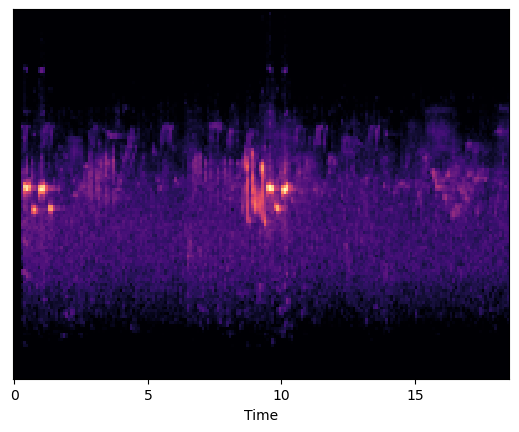

In [57]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

In [58]:
path = df.fullfilename.iloc[0]
compute_and_save_spec(path)

Error saving spectrograms to ../../data/dataset10/Turdus merula_Common Blackbird/spectrograms.h5: Unable to synchronously create dataset (name already exists)


In [59]:
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
spec.shape

(128, 3226)

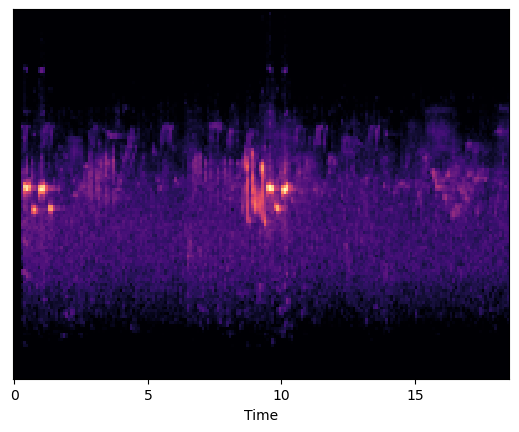

In [60]:
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:200], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

### Compute and save spectrograms for all audios in the dataset

In [61]:
for i in tqdm(range(len(df))):
    filepath = df.fullfilename.iloc[i]
    if not "spectrogram" in df.columns:
        df["spectrogram"] = None
    if not "length_spectrogram" in df.columns:
        df["length_spectrogram"] = None
        filepath = df.fullfilename.iloc[i]
    if df.loc[i, "spectrogram"] is None:
        df.loc[i, "length_spectrogram"] = compute_and_save_spec(filepath, return_length = True)
        df.loc[i, "spectrogram"] = Path(filepath).stem


df.to_csv("../../data/dataset10.csv", index = False)

100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 31531.38it/s]


(128, 2866)


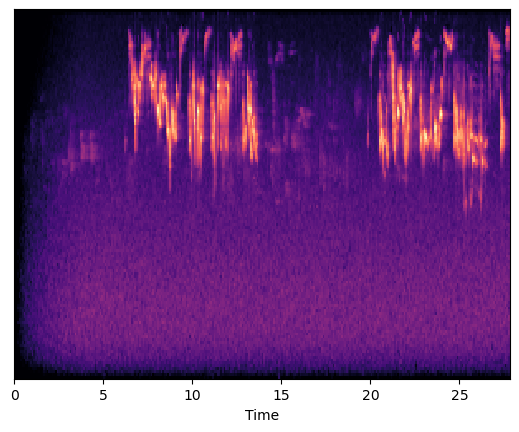

In [69]:
path = df.fullfilename.iloc[42]
spec = load_spectrogram_slice(os.path.dirname(path) + "/spectrograms.h5", Path(path).stem)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec[:, 0:300], sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax)

## Create data generator for training

### Helper functions

In [13]:
# Generates random integer # from https://www.kaggle.com/code/wengsilu/birdclef24pretraining
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)

# Generats random float
def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd

In [14]:
cfg.input_dim[1]

162

In [15]:
def load_random_spec_slice(df, ID):
    name = df.spectrogram.iloc[ID]
    hdf5_path = os.path.dirname(df.fullfilename.iloc[ID]) + "/spectrograms.h5"
    spec_length = df.length_spectrogram.iloc[ID]
    rdm = random_int(maxval= spec_length - cfg.input_dim[1])
    return load_spectrogram_slice(hdf5_path = hdf5_path, name = name, start_col = rdm, end_col = rdm + cfg.input_dim[1])

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, labels, dataframe,
                 batch_size=cfg.batch_size, 
                 dim=cfg.input_dim,
                 n_channels =  1,
                 n_classes=cfg.n_classes, 
                 shuffle=True
                ):
        'Initialization'
        self.dim = dim
        self.n_channels = n_channels
        self.batch_size = batch_size
        self.labels = labels
        self.list_IDs = list_IDs
        self.dataframe = dataframe
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = load_random_spec_slice(self.dataframe, ID).reshape(*self.dim, self.n_channels)
            # Store class
            y[i] = cfg.name2label[df.en.iloc[ID]]
        X = X.reshape(len(X), *self.dim, self.n_channels)
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

(128, 162)
(128, 162)


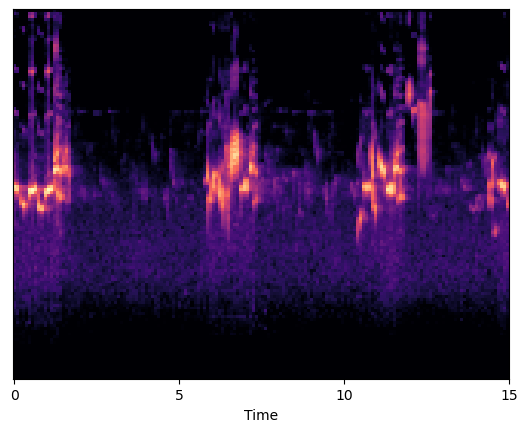

In [16]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,1)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax);
print(cfg.input_dim)

## Build model

In [50]:
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input

zscore_layer = tfe.layers.ZScoreMinMax()

def build_model():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Basemodel")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

### Test zscore_layer

In [51]:
specs = []
for i in tqdm(range(50)):
    specs.append(load_random_spec_slice(df, ID = i))
specs = np.array(specs)
print("Before zscore layer: ", specs.min(), specs.max())

print("After zscore layer: ", zscore_layer(specs).numpy().min(), zscore_layer(specs).numpy().max())


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 95.22it/s]

Before zscore layer:  -63.894543 38.449596
After zscore layer:  0.0 1.0


In [52]:
model = build_model()

Model: "Basemodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 162, 1)]     0         
                                                                 
 z_score_min_max (ZScoreMin  (None, 128, 162, 1)       0         
 Max)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 160, 32)      320       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 63, 80, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 61, 78, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 39, 64)        0 

## Train validation split

In [53]:
from sklearn.model_selection import train_test_split

id_train, id_val, y_train, y_val = train_test_split(range(len(df)), df["en"].to_list(), test_size = 0.3, random_state = cfg.seed)

training_generator = DataGenerator(id_train, y_train, df)
validation_generator = DataGenerator(id_val, y_val, df)

In [54]:
hist = model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True, verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50
13/13 - 11s - loss: 2.3209 - accuracy: 0.1442 - val_loss: 2.3162 - val_accuracy: 0.0625 - 11s/epoch - 815ms/step
Epoch 2/50
13/13 - 9s - loss: 2.2951 - accuracy: 0.1394 - val_loss: 2.3470 - val_accuracy: 0.0625 - 9s/epoch - 707ms/step
Epoch 3/50
13/13 - 10s - loss: 2.2783 - accuracy: 0.1346 - val_loss: 2.3351 - val_accuracy: 0.0625 - 10s/epoch - 772ms/step
Epoch 4/50
13/13 - 10s - loss: 2.2891 - accuracy: 0.1058 - val_loss: 2.3142 - val_accuracy: 0.0500 - 10s/epoch - 737ms/step
Epoch 5/50
13/13 - 9s - loss: 2.2502 - accuracy: 0.1394 - val_loss: 2.3250 - val_accuracy: 0.0500 - 9s/epoch - 726ms/step
Epoch 6/50
13/13 - 10s - loss: 2.2446 - accuracy: 0.1490 - val_loss: 2.3566 - val_accuracy: 0.0625 - 10s/epoch - 734ms/step
Epoch 7/50
13/13 - 10s - loss: 2.1763 - accuracy: 0.2019 - val_loss: 2.6239 - val_accuracy: 0.1375 - 10s/epoch - 734ms/step
Epoch 8/50
13/13 - 10s - loss: 2.1800 - accuracy: 0.2067 - val_loss: 2.3829 - val_accuracy: 0.0750 - 10s/epoch - 742ms/step
Epoch 9/50
1

In [55]:
def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['accuracy'])
    plt.plot(network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

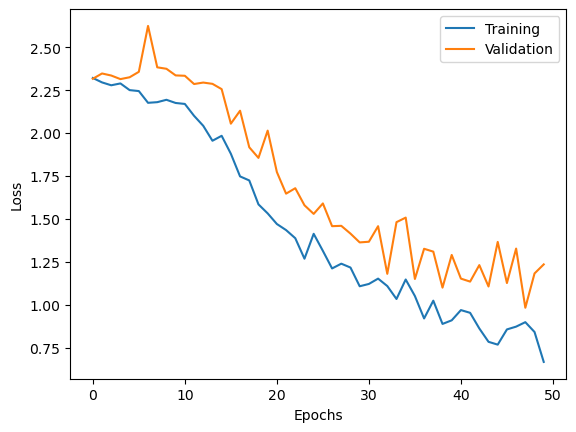

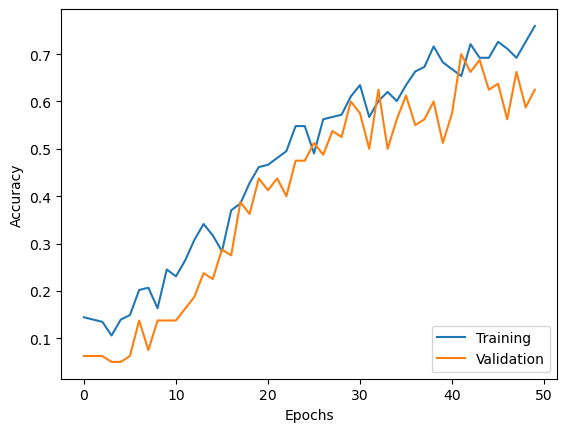

In [56]:
plot_history(hist)

### Train for another n_epochs

In [101]:
hist2 = model.fit(training_generator, 
                  validation_data=validation_generator,
                  use_multiprocessing=True, verbose = 2, epochs = cfg.n_epochs)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Epoch 1/50
13/13 - 10s - loss: 0.7143 - accuracy: 0.7356 - val_loss: 1.0636 - val_accuracy: 0.6500 - 10s/epoch - 742ms/step
Epoch 2/50
13/13 - 5s - loss: 0.6950 - accuracy: 0.7356 - val_loss: 1.2545 - val_accuracy: 0.6250 - 5s/epoch - 349ms/step
Epoch 3/50
13/13 - 9s - loss: 0.6699 - accuracy: 0.7692 - val_loss: 0.9874 - val_accuracy: 0.6000 - 9s/epoch - 727ms/step
Epoch 4/50
13/13 - 10s - loss: 0.5766 - accuracy: 0.8269 - val_loss: 1.0821 - val_accuracy: 0.6625 - 10s/epoch - 745ms/step
Epoch 5/50
13/13 - 5s - loss: 0.6009 - accuracy: 0.7885 - val_loss: 1.2160 - val_accuracy: 0.6375 - 5s/epoch - 350ms/step
Epoch 6/50
13/13 - 10s - loss: 0.6322 - accuracy: 0.7740 - val_loss: 1.2261 - val_accuracy: 0.6625 - 10s/epoch - 735ms/step
Epoch 7/50
13/13 - 9s - loss: 0.6677 - accuracy: 0.7500 - val_loss: 1.3624 - val_accuracy: 0.6125 - 9s/epoch

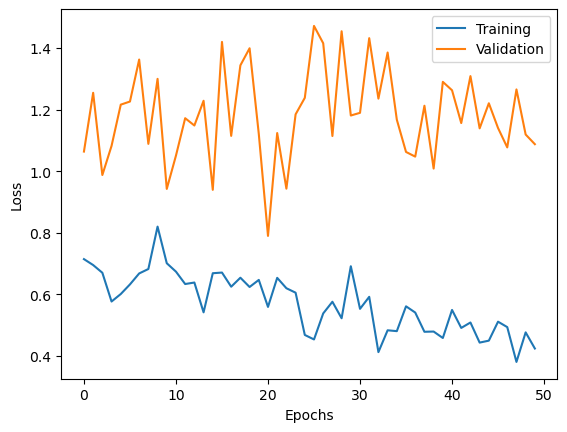

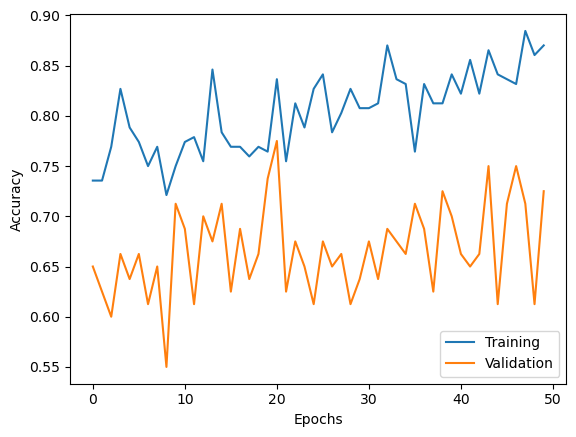

In [105]:
plot_history(hist2)

## Include time frequency mask layer
### (not working yet, idk why)

In [87]:
tfm_layer = tfe.layers.TimeFreqMask(freq_mask_prob=0.5,
                                  num_freq_masks=2,
                                  freq_mask_param=15,
                                  time_mask_prob=0.5,
                                  num_time_masks=3,
                                  time_mask_param=15,
                                  time_last=True,
                        )

(128, 162)


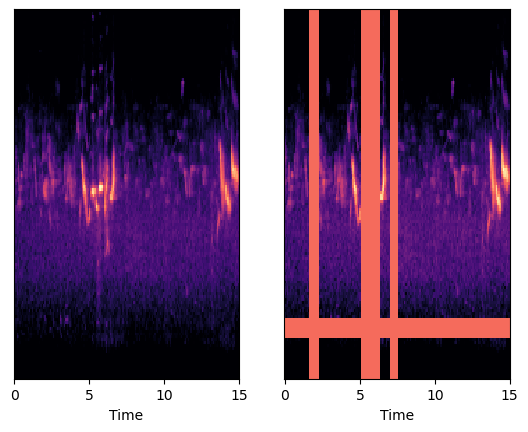

In [89]:
spec = load_random_spec_slice(df, ID = 0)
print(spec.shape)
fig, ax = plt.subplots(1,2)
librosa.display.specshow(spec, sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[0]);
librosa.display.specshow(tfm_layer(spec.reshape(1, *cfg.input_dim, 1), training = True).numpy().reshape(*cfg.input_dim), 
                         sr=cfg.sr, hop_length=cfg.hop_length,
                         x_axis='time', ax=ax[1]);

In [95]:
def build_model2():
    inp = Input(shape=(*cfg.input_dim, 1))
    
    # Normalize
    x = zscore_layer(inp)
    # Time Frequency masking
    x = tfm_layer(x)
    # Base model
    x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='valid', activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding="valid")(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(32, activation='relu')(x)
    output = Dense(cfg.n_classes, activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs=inp, outputs=output, name = "Model2")
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [96]:
model2 = build_model2()

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 162, 1)]     0         
                                                                 
 z_score_min_max (ZScoreMin  (None, 128, 162, 1)       0         
 Max)                                                            
                                                                 
 time_freq_mask (TimeFreqMa  (None, 128, 162, 1)       0         
 sk)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 126, 160, 32)      320       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 63, 80, 32)        0         
 ng2D)                                                           
                                                            

In [100]:
hist2 = model2.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True, verbose = 2, epochs = cfg.n_epochs)

Epoch 1/50


ValueError: in user code:

    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileklvg8o3s.py", line 69, in tf__call
        ag__.if_stmt(ag__.not_(ag__.ld(training)), if_body, else_body, get_state_2, set_state_2, ('do_return', 'retval_'), 2)
    File "/tmp/__autograph_generated_fileklvg8o3s.py", line 45, in else_body
        ag__.for_stmt(ag__.converted_call(ag__.ld(tf).range, (ag__.ld(self).num_time_masks,), None, fscope), None, loop_body, get_state, set_state, ('x',), {'iterate_names': '_'})
    File "/tmp/__autograph_generated_fileklvg8o3s.py", line 43, in loop_body
        x = ag__.converted_call(ag__.ld(self).mask_along_axis_iid, (ag__.ld(x), ag__.ld(self).time_mask_param, 0, 2 + ag__.converted_call(ag__.ld(int), (ag__.ld(self).time_last,), None, fscope), ag__.ld(self).time_mask_prob), None, fscope)
    File "/tmp/__autograph_generated_filesd2g40wc.py", line 83, in tf__mask_along_axis_iid
        ag__.if_stmt(ag__.converted_call(ag__.ld(tf).random.uniform, ([],), None, fscope) > ag__.ld(p), if_body_2, else_body_2, get_state_2, set_state_2, ('do_return', 'retval_', 'specs'), 2)
    File "/tmp/__autograph_generated_filesd2g40wc.py", line 60, in else_body_2
        min_value = ag__.converted_call(ag__.ld(tf).random.uniform, (), dict(shape=ag__.ld(shape)[:2], dtype=ag__.ld(dtype)), fscope) * (ag__.ld(specs).shape[ag__.ld(axis)] - ag__.ld(value))

    ValueError: Exception encountered when calling layer 'time_freq_mask' (type TimeFreqMask).
    
    in user code:
    
        File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/tensorflow_extra/layers.py", line 402, in call  *
            x = self.mask_along_axis_iid(
        File "/home/cfr/.local/conda/envs/ML_Birds/lib/python3.11/site-packages/tensorflow_extra/layers.py", line 442, in mask_along_axis_iid  *
            min_value = tf.random.uniform(shape=shape[:2], dtype=dtype) * (
    
        ValueError: None values not supported.
    
    
    Call arguments received by layer 'time_freq_mask' (type TimeFreqMask):
      • inputs=tf.Tensor(shape=(None, None, None, None), dtype=float32)
      • training=True
